In [1]:
#importing packages & libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import pickle
%matplotlib inline
test_images = 'test_images/'
camera_cal_dir = 'camera_cal/'

In [ ]:
# 1, Camera distortion calibration with chess board image
nx = 9 # number of inside corners in x
ny = 6 # number of inside corners in y
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx, 3), np.float32)
objp[:,:-1] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = os.listdir(camera_cal_dir)
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
n = 0
for fname in images:
    img = cv2.imread(camera_cal_dir+fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        n += 1
        # print(fname)
        objpoints.append(objp)
        cv2.cornerSubPix(gray,corners,(11,11), (-1,-1),criteria)
        imgpoints.append(corners)
print('Total good calibration images: ', n)
# Calibrate
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(mtx)
print(mtx.shape)

with open('./camera_dist_param.p', 'wb') as f:
    pickle.dump((mtx, dist), f)
print('Camera Distortion Parameters Saved!')

In [ ]:
# 3, perspective transform
# 
image_list = os.listdir(test_images)
# print(image_list)
# image_file = image_list[3]
image_file = 'straight_lines1.jpg'
image = mpimg.imread(test_images + image_file)
print('This image is:', type(image), 'with dimesions:', image.shape)
print('Max:', image.max(), 'Min:', image.min())
plt.title(image_file)
plt.imshow(image)
plt.savefig(image_results + 'original_image.png')

image_undist = cv2.undistort(image, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(image_undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig(image_results + 'regular_image_cal.png')

# find the 4 points, image size: 720, 1280
im_xsize = image_undist.shape[1]
im_ysize = image_undist.shape[0]
x_ratio = im_xsize/1280
y_ratio = im_ysize/720
print(image_undist.shape)
vertices = np.array([(np.round(230*x_ratio), np.round(700*x_ratio)), (np.round(580/x_ratio), np.round(460*y_ratio)), \
                      (np.round(702*x_ratio), np.round(460*y_ratio)), (np.round(1080*x_ratio), np.round(700*y_ratio))], dtype=np.int32)
plt.figure(figsize=(24, 9))
plt.imshow(image_undist)
plt.plot(vertices[:, 0], vertices[:, 1], 'b--', lw=2)
plt.savefig(image_results + 'four-points.png')
src = np.float32(vertices)
# dst = np.float32([[275, 680], [275, 450], [1055, 450], [1055, 680]])
x_offset = 290 # offset for dst points
y_offset = 0
# For source points I'm grabbing the outer four detected corners
# src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
# For destination points, I'm arbitrarily choosing some points to be
# a nice fit for displaying our warped result 
# again, not exact, but close enough for our purpose
dst = np.float32([[x_offset, im_ysize-y_offset], [x_offset, y_offset], [im_xsize-x_offset, y_offset], [im_xsize-x_offset, im_ysize-y_offset]])
print(src, dst)
M = cv2.getPerspectiveTransform(src, dst)
invM = cv2.getPerspectiveTransform(dst, src)
with open('./camera_warp_param.p', 'wb') as f:
    pickle.dump((M, invM), f)
print('Camera Warped Parameters Saved!')
# e) use cv2.warpPerspective() to warp your image to a top-down view
image_top_down = cv2.warpPerspective(image_undist, M, image_undist.shape[1::-1], flags=cv2.INTER_LINEAR)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.plot(vertices[:, 0], vertices[:, 1], 'r--', lw=5)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(image_top_down)
ax2.plot(dst[:, 0], dst[:, 1], 'r--', lw=5)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig(image_results + 'undist_warp.png')

In [89]:
# load camera distortion parameters
with open('./camera_dist_param.p', 'rb') as f:
    dist_param = pickle.load(f)
# load perspective warped parameters
with open('./camera_warp_param.p', 'rb') as f:
    warp_param = pickle.load(f)
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.detected = 0
        
        self.frame_cnt = 0
        
        self.all_fit = []
        self.all_fit_cir = []
        self.all_curverad = []
        self.all_offset = []

        self.current_fit = []
        self.current_fit_cir = []
        self.current_curverad = []
        self.current_offset = []
        self.mis_frame = 0
left_lane = Line()
right_lane = Line()

In [90]:
# vedio test bench
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# clip1 = VideoFileClip("harder_challenge_video.mp4")
# white_output = 'wharder_challenge_video.mp4'
# clip1 = VideoFileClip("challenge_video.mp4")
# white_output = 'challenge_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_output = 'project_video_output.mp4'
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
# white_clip = clip1.fl_image(lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2YUV))

In [91]:
%time white_clip.write_videofile(white_output, audio=False)
# play video inline
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:00<06:34,  3.20it/s]


  0%|          | 2/1261 [00:00<06:36,  3.17it/s]


  0%|          | 3/1261 [00:00<06:33,  3.20it/s]

Fitting failed @ Frame:  4





  0%|          | 4/1261 [00:01<06:31,  3.21it/s]

Fitting failed @ Frame:  5





  0%|          | 5/1261 [00:01<07:04,  2.96it/s]


  0%|          | 6/1261 [00:01<06:56,  3.01it/s]


  1%|          | 7/1261 [00:02<06:57,  3.01it/s]


  1%|          | 8/1261 [00:02<07:07,  2.93it/s]

Fitting failed @ Frame:  9





  1%|          | 9/1261 [00:02<06:56,  3.00it/s]

Fitting failed @ Frame:  10





  1%|          | 10/1261 [00:03<07:11,  2.90it/s]


  1%|          | 11/1261 [00:03<06:53,  3.02it/s]


  1%|          | 12/1261 [00:03<06:50,  3.04it/s]


  1%|          | 13/1261 [00:04<07:05,  2.93it/s]


  1%|          | 14/1261 [00:04<06:51,  3.03it/s]


  1%|          | 15/1261 [00:04<06:41,  3.11it/s]


  1%|▏         | 16/1261 [00:05<06:32,  3.17it/s]


  1%|▏         | 17/1261 [00:05<06:26,  3.22it/s]


  1%|▏         | 18/1261 [00:05<06:23,  3.24it/s]


  2%|▏         | 19/1261 [00:06<06:20,  3.26it/s]


  2%|▏         | 20/1261 [00:06<06:41,  3.09it/s]


  2%|▏         | 21/1261 [00:06<06:50,  3.02it/s]


  2%|▏         | 22/1261 [00:07<06:37,  3.12it/s]


  2%|▏         | 23/1261 [00:07<07:09,  2.88it/s]


  2%|▏         | 24/1261 [00:07<06:51,  3.00it/s]


  2%|▏         | 25/1261 [00:08<06:41,  3.08it/s]


  2%|▏         | 26/1261 [00:08<06:32,  3.15it/s]


  2%|▏         | 27/1261 [00:08<06:28,  3.18it/s]


  2%|▏         | 28/1261 [00:09<06:24,  3.21it/s]


  2%|▏   

Fitting failed @ Frame:  31





  2%|▏         | 31/1261 [00:09<06:15,  3.27it/s]


  3%|▎         | 32/1261 [00:10<06:11,  3.31it/s]


  3%|▎         | 33/1261 [00:10<06:08,  3.33it/s]


  3%|▎         | 34/1261 [00:10<06:24,  3.19it/s]

Fitting failed @ Frame:  35





  3%|▎         | 35/1261 [00:11<06:35,  3.10it/s]


  3%|▎         | 36/1261 [00:11<06:53,  2.96it/s]


  3%|▎         | 37/1261 [00:12<07:08,  2.86it/s]


  3%|▎         | 38/1261 [00:12<07:08,  2.85it/s]


  3%|▎         | 39/1261 [00:12<07:02,  2.89it/s]

Fitting failed @ Frame:  40





  3%|▎         | 40/1261 [00:13<07:04,  2.87it/s]

Fitting failed @ Frame:  41
Fitting failed @ Frame:  41





  3%|▎         | 41/1261 [00:13<07:16,  2.80it/s]

Fitting failed @ Frame:  42
Fitting failed @ Frame:  42





  3%|▎         | 42/1261 [00:13<07:15,  2.80it/s]

Fitting failed @ Frame:  43
Fitting failed @ Frame:  43





  3%|▎         | 43/1261 [00:14<06:59,  2.90it/s]


  3%|▎         | 44/1261 [00:14<06:42,  3.02it/s]


  4%|▎         | 45/1261 [00:14<06:56,  2.92it/s]


  4%|▎         | 46/1261 [00:15<06:45,  3.00it/s]


  4%|▎         | 47/1261 [00:15<06:59,  2.90it/s]


  4%|▍         | 48/1261 [00:15<06:45,  2.99it/s]


  4%|▍         | 49/1261 [00:16<06:57,  2.90it/s]


  4%|▍         | 50/1261 [00:16<06:54,  2.92it/s]


  4%|▍         | 51/1261 [00:16<07:05,  2.84it/s]


  4%|▍         | 52/1261 [00:17<07:00,  2.88it/s]


  4%|▍         | 53/1261 [00:17<07:06,  2.83it/s]

Fitting failed @ Frame:  54





  4%|▍         | 54/1261 [00:17<07:09,  2.81it/s]

Fitting failed @ Frame:  55





  4%|▍         | 55/1261 [00:18<06:54,  2.91it/s]

Fitting failed @ Frame:  56





  4%|▍         | 56/1261 [00:18<06:46,  2.97it/s]


  5%|▍         | 57/1261 [00:18<06:39,  3.02it/s]


  5%|▍         | 58/1261 [00:19<06:36,  3.03it/s]


  5%|▍         | 59/1261 [00:19<06:30,  3.08it/s]


  5%|▍         | 60/1261 [00:19<06:54,  2.90it/s]


  5%|▍         | 61/1261 [00:20<06:40,  3.00it/s]


  5%|▍         | 62/1261 [00:20<06:29,  3.08it/s]


  5%|▍         | 63/1261 [00:20<06:36,  3.02it/s]


  5%|▌         | 64/1261 [00:21<06:48,  2.93it/s]

Fitting failed @ Frame:  65





  5%|▌         | 65/1261 [00:21<07:08,  2.79it/s]

Fitting failed @ Frame:  66





  5%|▌         | 66/1261 [00:21<07:08,  2.79it/s]


  5%|▌         | 67/1261 [00:22<07:04,  2.81it/s]


  5%|▌         | 68/1261 [00:22<07:10,  2.77it/s]


  5%|▌         | 69/1261 [00:23<07:02,  2.82it/s]


  6%|▌         | 70/1261 [00:23<06:59,  2.84it/s]


  6%|▌         | 71/1261 [00:23<06:46,  2.93it/s]


  6%|▌         | 72/1261 [00:24<07:04,  2.80it/s]


  6%|▌         | 73/1261 [00:24<06:48,  2.91it/s]


  6%|▌         | 74/1261 [00:24<07:00,  2.82it/s]


  6%|▌         | 75/1261 [00:25<07:06,  2.78it/s]


  6%|▌         | 76/1261 [00:25<07:11,  2.75it/s]

Fitting failed @ Frame:  77





  6%|▌         | 77/1261 [00:25<07:12,  2.74it/s]


  6%|▌         | 78/1261 [00:26<07:13,  2.73it/s]

Fitting failed @ Frame:  79





  6%|▋         | 79/1261 [00:26<07:12,  2.73it/s]

Fitting failed @ Frame:  80





  6%|▋         | 80/1261 [00:27<07:20,  2.68it/s]

Fitting failed @ Frame:  81





  6%|▋         | 81/1261 [00:27<07:23,  2.66it/s]


  7%|▋         | 82/1261 [00:27<07:14,  2.71it/s]


  7%|▋         | 83/1261 [00:28<07:17,  2.69it/s]


  7%|▋         | 84/1261 [00:28<07:18,  2.69it/s]


  7%|▋         | 85/1261 [00:28<07:17,  2.69it/s]


  7%|▋         | 86/1261 [00:29<07:11,  2.72it/s]


  7%|▋         | 87/1261 [00:29<07:17,  2.68it/s]


  7%|▋         | 88/1261 [00:29<07:05,  2.76it/s]


  7%|▋         | 89/1261 [00:30<07:13,  2.70it/s]

Fitting failed @ Frame:  90





  7%|▋         | 90/1261 [00:30<07:05,  2.75it/s]

Fitting failed @ Frame:  91





  7%|▋         | 91/1261 [00:31<07:19,  2.66it/s]

Fitting failed @ Frame:  92





  7%|▋         | 92/1261 [00:31<06:57,  2.80it/s]


  7%|▋         | 93/1261 [00:31<06:44,  2.89it/s]


  7%|▋         | 94/1261 [00:32<06:33,  2.97it/s]


  8%|▊         | 95/1261 [00:32<06:26,  3.02it/s]


  8%|▊         | 96/1261 [00:32<06:30,  2.98it/s]


  8%|▊         | 97/1261 [00:33<06:45,  2.87it/s]


  8%|▊         | 98/1261 [00:33<06:55,  2.80it/s]


  8%|▊         | 99/1261 [00:33<07:11,  2.69it/s]


  8%|▊         | 100/1261 [00:34<07:01,  2.75it/s]


  8%|▊         | 101/1261 [00:34<06:56,  2.79it/s]


  8%|▊         | 102/1261 [00:34<06:46,  2.85it/s]

Fitting failed @ Frame:  103





  8%|▊         | 103/1261 [00:35<06:39,  2.90it/s]

Fitting failed @ Frame:  104





  8%|▊         | 104/1261 [00:35<06:28,  2.98it/s]

Fitting failed @ Frame:  105





  8%|▊         | 105/1261 [00:35<06:20,  3.04it/s]

Fitting failed @ Frame:  106





  8%|▊         | 106/1261 [00:36<06:14,  3.08it/s]


  8%|▊         | 107/1261 [00:36<06:10,  3.12it/s]


  9%|▊         | 108/1261 [00:36<06:08,  3.13it/s]


  9%|▊         | 109/1261 [00:37<06:04,  3.16it/s]


  9%|▊         | 110/1261 [00:37<05:59,  3.20it/s]


  9%|▉         | 111/1261 [00:37<05:58,  3.21it/s]


  9%|▉         | 112/1261 [00:38<05:54,  3.24it/s]


  9%|▉         | 113/1261 [00:38<05:54,  3.24it/s]


  9%|▉         | 114/1261 [00:38<05:53,  3.25it/s]


  9%|▉         | 115/1261 [00:38<05:51,  3.26it/s]

Fitting failed @ Frame:  116





  9%|▉         | 116/1261 [00:39<05:52,  3.24it/s]

Fitting failed @ Frame:  117





  9%|▉         | 117/1261 [00:39<05:54,  3.23it/s]

Fitting failed @ Frame:  118





  9%|▉         | 118/1261 [00:39<05:55,  3.22it/s]

Fitting failed @ Frame:  119





  9%|▉         | 119/1261 [00:40<05:55,  3.21it/s]


 10%|▉         | 120/1261 [00:40<06:14,  3.05it/s]


 10%|▉         | 121/1261 [00:40<06:43,  2.82it/s]


 10%|▉         | 122/1261 [00:41<06:29,  2.92it/s]


 10%|▉         | 123/1261 [00:41<06:17,  3.01it/s]


 10%|▉         | 124/1261 [00:41<06:19,  3.00it/s]


 10%|▉         | 125/1261 [00:42<06:22,  2.97it/s]


 10%|▉         | 126/1261 [00:42<06:19,  2.99it/s]


 10%|█         | 127/1261 [00:42<06:10,  3.06it/s]

Fitting failed @ Frame:  128





 10%|█         | 128/1261 [00:43<06:20,  2.98it/s]

Fitting failed @ Frame:  129





 10%|█         | 129/1261 [00:43<06:17,  2.99it/s]

Fitting failed @ Frame:  130





 10%|█         | 130/1261 [00:43<06:11,  3.05it/s]


 10%|█         | 131/1261 [00:44<06:44,  2.79it/s]


 10%|█         | 132/1261 [00:44<07:04,  2.66it/s]


 11%|█         | 133/1261 [00:45<07:01,  2.68it/s]


 11%|█         | 134/1261 [00:45<06:52,  2.73it/s]


 11%|█         | 135/1261 [00:45<06:49,  2.75it/s]


 11%|█         | 136/1261 [00:46<06:44,  2.78it/s]


 11%|█         | 137/1261 [00:46<06:44,  2.78it/s]


 11%|█         | 138/1261 [00:46<06:41,  2.80it/s]


 11%|█         | 139/1261 [00:47<06:35,  2.84it/s]


 11%|█         | 140/1261 [00:47<06:39,  2.80it/s]


 11%|█         | 141/1261 [00:47<06:41,  2.79it/s]


 11%|█▏        | 142/1261 [00:48<06:40,  2.79it/s]

Fitting failed @ Frame:  143





 11%|█▏        | 143/1261 [00:48<06:39,  2.80it/s]


 11%|█▏        | 144/1261 [00:49<06:33,  2.84it/s]


 11%|█▏        | 145/1261 [00:49<06:33,  2.84it/s]


 12%|█▏        | 146/1261 [00:49<06:22,  2.91it/s]


 12%|█▏        | 147/1261 [00:50<06:13,  2.99it/s]


 12%|█▏        | 148/1261 [00:50<06:04,  3.06it/s]


 12%|█▏        | 149/1261 [00:50<05:56,  3.12it/s]


 12%|█▏        | 150/1261 [00:50<05:58,  3.10it/s]


 12%|█▏        | 151/1261 [00:51<05:58,  3.09it/s]


 12%|█▏        | 152/1261 [00:51<05:54,  3.12it/s]

Fitting failed @ Frame:  153





 12%|█▏        | 153/1261 [00:51<05:51,  3.15it/s]

Fitting failed @ Frame:  154





 12%|█▏        | 154/1261 [00:52<05:52,  3.14it/s]

Fitting failed @ Frame:  155





 12%|█▏        | 155/1261 [00:52<05:49,  3.17it/s]


 12%|█▏        | 156/1261 [00:52<06:00,  3.07it/s]


 12%|█▏        | 157/1261 [00:53<05:55,  3.11it/s]


 13%|█▎        | 158/1261 [00:53<05:55,  3.10it/s]


 13%|█▎        | 159/1261 [00:53<05:51,  3.14it/s]

Fitting failed @ Frame:  160





 13%|█▎        | 160/1261 [00:54<05:48,  3.16it/s]


 13%|█▎        | 161/1261 [00:54<05:44,  3.19it/s]


 13%|█▎        | 162/1261 [00:54<05:45,  3.18it/s]


 13%|█▎        | 163/1261 [00:55<05:39,  3.23it/s]


 13%|█▎        | 164/1261 [00:55<05:40,  3.22it/s]


 13%|█▎        | 165/1261 [00:55<05:41,  3.21it/s]

Fitting failed @ Frame:  166





 13%|█▎        | 166/1261 [00:56<05:47,  3.15it/s]

Fitting failed @ Frame:  167





 13%|█▎        | 167/1261 [00:56<05:45,  3.16it/s]


 13%|█▎        | 168/1261 [00:56<05:44,  3.17it/s]


 13%|█▎        | 169/1261 [00:56<05:41,  3.20it/s]


 13%|█▎        | 170/1261 [00:57<05:39,  3.21it/s]


 14%|█▎        | 171/1261 [00:57<05:43,  3.18it/s]


 14%|█▎        | 172/1261 [00:57<05:56,  3.05it/s]


 14%|█▎        | 173/1261 [00:58<05:59,  3.02it/s]


 14%|█▍        | 174/1261 [00:58<06:11,  2.93it/s]


 14%|█▍        | 175/1261 [00:58<06:06,  2.96it/s]

Fitting failed @ Frame:  176





 14%|█▍        | 176/1261 [00:59<06:02,  2.99it/s]

Fitting failed @ Frame:  177





 14%|█▍        | 177/1261 [00:59<05:59,  3.01it/s]

Fitting failed @ Frame:  178





 14%|█▍        | 178/1261 [00:59<05:55,  3.04it/s]

Fitting failed @ Frame:  179





 14%|█▍        | 179/1261 [01:00<05:48,  3.10it/s]

Fitting failed @ Frame:  180
Detection Failed @ Frame:  180





 14%|█▍        | 180/1261 [01:00<05:43,  3.15it/s]

Fitting failed @ Frame:  181
Detection Failed @ Frame:  181





 14%|█▍        | 181/1261 [01:00<05:41,  3.16it/s]


 14%|█▍        | 182/1261 [01:01<05:43,  3.15it/s]


 15%|█▍        | 183/1261 [01:01<05:49,  3.08it/s]


 15%|█▍        | 184/1261 [01:01<05:46,  3.11it/s]


 15%|█▍        | 185/1261 [01:02<05:37,  3.19it/s]


 15%|█▍        | 186/1261 [01:02<05:31,  3.24it/s]


 15%|█▍        | 187/1261 [01:02<05:33,  3.22it/s]

Fitting failed @ Frame:  188
Fitting failed @ Frame:  188





 15%|█▍        | 188/1261 [01:03<05:38,  3.17it/s]

Fitting failed @ Frame:  189
Fitting failed @ Frame:  189





 15%|█▍        | 189/1261 [01:03<05:35,  3.20it/s]

Fitting failed @ Frame:  190





 15%|█▌        | 190/1261 [01:03<05:33,  3.21it/s]

Fitting failed @ Frame:  191





 15%|█▌        | 191/1261 [01:04<05:36,  3.18it/s]

Fitting failed @ Frame:  192
Detection Failed @ Frame:  192





 15%|█▌        | 192/1261 [01:04<05:35,  3.19it/s]


 15%|█▌        | 193/1261 [01:04<05:33,  3.20it/s]


 15%|█▌        | 194/1261 [01:04<05:39,  3.14it/s]


 15%|█▌        | 195/1261 [01:05<05:36,  3.17it/s]


 16%|█▌        | 196/1261 [01:05<05:30,  3.22it/s]


 16%|█▌        | 197/1261 [01:05<05:28,  3.24it/s]


 16%|█▌        | 198/1261 [01:06<05:27,  3.24it/s]


 16%|█▌        | 199/1261 [01:06<05:24,  3.27it/s]


 16%|█▌        | 200/1261 [01:06<05:23,  3.28it/s]


 16%|█▌        | 201/1261 [01:07<05:22,  3.29it/s]


 16%|█▌        | 202/1261 [01:07<05:26,  3.24it/s]


 16%|█▌        | 203/1261 [01:07<05:29,  3.21it/s]


 16%|█▌        | 204/1261 [01:08<05:39,  3.11it/s]

Fitting failed @ Frame:  205





 16%|█▋        | 205/1261 [01:08<05:34,  3.15it/s]

Fitting failed @ Frame:  206





 16%|█▋        | 206/1261 [01:08<05:31,  3.18it/s]


 16%|█▋        | 207/1261 [01:09<05:28,  3.21it/s]


 16%|█▋        | 208/1261 [01:09<05:24,  3.24it/s]


 17%|█▋        | 209/1261 [01:09<05:22,  3.26it/s]


 17%|█▋        | 210/1261 [01:09<05:24,  3.24it/s]


 17%|█▋        | 211/1261 [01:10<05:26,  3.22it/s]


 17%|█▋        | 212/1261 [01:10<05:27,  3.20it/s]


 17%|█▋        | 213/1261 [01:10<05:27,  3.20it/s]


 17%|█▋        | 214/1261 [01:11<05:24,  3.23it/s]


 17%|█▋        | 215/1261 [01:11<05:27,  3.19it/s]

Fitting failed @ Frame:  216





 17%|█▋        | 216/1261 [01:11<05:31,  3.15it/s]

Fitting failed @ Frame:  217





 17%|█▋        | 217/1261 [01:12<05:27,  3.19it/s]


 17%|█▋        | 218/1261 [01:12<05:23,  3.22it/s]


 17%|█▋        | 219/1261 [01:12<05:21,  3.24it/s]


 17%|█▋        | 220/1261 [01:13<05:20,  3.25it/s]


 18%|█▊        | 221/1261 [01:13<05:17,  3.28it/s]


 18%|█▊        | 222/1261 [01:13<05:27,  3.17it/s]


 18%|█▊        | 223/1261 [01:13<05:23,  3.21it/s]


 18%|█▊        | 224/1261 [01:14<05:20,  3.23it/s]


 18%|█▊        | 225/1261 [01:14<05:25,  3.19it/s]


 18%|█▊        | 226/1261 [01:14<05:22,  3.21it/s]

Fitting failed @ Frame:  227





 18%|█▊        | 227/1261 [01:15<05:22,  3.21it/s]

Fitting failed @ Frame:  228





 18%|█▊        | 228/1261 [01:15<05:29,  3.13it/s]

Fitting failed @ Frame:  229





 18%|█▊        | 229/1261 [01:15<05:50,  2.94it/s]


 18%|█▊        | 230/1261 [01:16<06:03,  2.84it/s]


 18%|█▊        | 231/1261 [01:16<06:19,  2.72it/s]


 18%|█▊        | 232/1261 [01:17<06:13,  2.76it/s]


 18%|█▊        | 233/1261 [01:17<06:02,  2.84it/s]


 19%|█▊        | 234/1261 [01:17<05:53,  2.91it/s]


 19%|█▊        | 235/1261 [01:18<05:45,  2.97it/s]


 19%|█▊        | 236/1261 [01:18<05:47,  2.95it/s]


 19%|█▉        | 237/1261 [01:18<05:42,  2.99it/s]


 19%|█▉        | 238/1261 [01:19<06:14,  2.73it/s]

Fitting failed @ Frame:  239





 19%|█▉        | 239/1261 [01:19<06:14,  2.73it/s]

Fitting failed @ Frame:  240





 19%|█▉        | 240/1261 [01:19<06:22,  2.67it/s]

Fitting failed @ Frame:  241





 19%|█▉        | 241/1261 [01:20<06:30,  2.61it/s]

Fitting failed @ Frame:  242





 19%|█▉        | 242/1261 [01:20<06:26,  2.63it/s]


 19%|█▉        | 243/1261 [01:21<06:47,  2.50it/s]


 19%|█▉        | 244/1261 [01:21<06:53,  2.46it/s]


 19%|█▉        | 245/1261 [01:21<06:29,  2.61it/s]


 20%|█▉        | 246/1261 [01:22<06:06,  2.77it/s]


 20%|█▉        | 247/1261 [01:22<05:50,  2.89it/s]


 20%|█▉        | 248/1261 [01:22<05:42,  2.96it/s]

Fitting failed @ Frame:  249





 20%|█▉        | 249/1261 [01:23<06:01,  2.80it/s]

Fitting failed @ Frame:  250





 20%|█▉        | 250/1261 [01:23<06:23,  2.64it/s]

Fitting failed @ Frame:  251





 20%|█▉        | 251/1261 [01:24<06:06,  2.76it/s]

Fitting failed @ Frame:  252





 20%|█▉        | 252/1261 [01:24<05:54,  2.85it/s]

Fitting failed @ Frame:  253
Detection Failed @ Frame:  253





 20%|██        | 253/1261 [01:24<05:43,  2.93it/s]


 20%|██        | 254/1261 [01:24<05:34,  3.01it/s]


 20%|██        | 255/1261 [01:25<05:30,  3.04it/s]


 20%|██        | 256/1261 [01:25<05:24,  3.10it/s]


 20%|██        | 257/1261 [01:25<05:22,  3.11it/s]


 20%|██        | 258/1261 [01:26<05:24,  3.09it/s]


 21%|██        | 259/1261 [01:26<05:27,  3.06it/s]


 21%|██        | 260/1261 [01:26<05:39,  2.95it/s]

Fitting failed @ Frame:  261





 21%|██        | 261/1261 [01:27<05:54,  2.82it/s]


 21%|██        | 262/1261 [01:27<06:12,  2.68it/s]

Fitting failed @ Frame:  263





 21%|██        | 263/1261 [01:28<06:01,  2.76it/s]

Fitting failed @ Frame:  264





 21%|██        | 264/1261 [01:28<05:45,  2.88it/s]

Fitting failed @ Frame:  265





 21%|██        | 265/1261 [01:28<05:37,  2.95it/s]


 21%|██        | 266/1261 [01:29<05:53,  2.82it/s]


 21%|██        | 267/1261 [01:29<05:46,  2.87it/s]


 21%|██▏       | 268/1261 [01:29<05:59,  2.76it/s]


 21%|██▏       | 269/1261 [01:30<06:10,  2.68it/s]


 21%|██▏       | 270/1261 [01:30<06:09,  2.68it/s]

Fitting failed @ Frame:  271





 21%|██▏       | 271/1261 [01:30<06:07,  2.70it/s]


 22%|██▏       | 272/1261 [01:31<05:46,  2.85it/s]


 22%|██▏       | 273/1261 [01:31<05:36,  2.94it/s]


 22%|██▏       | 274/1261 [01:31<05:38,  2.92it/s]

Fitting failed @ Frame:  275





 22%|██▏       | 275/1261 [01:32<05:45,  2.85it/s]

Fitting failed @ Frame:  276





 22%|██▏       | 276/1261 [01:32<05:36,  2.93it/s]


 22%|██▏       | 277/1261 [01:32<05:26,  3.01it/s]


 22%|██▏       | 278/1261 [01:33<05:26,  3.01it/s]


 22%|██▏       | 279/1261 [01:33<05:20,  3.07it/s]


 22%|██▏       | 280/1261 [01:33<05:11,  3.15it/s]


 22%|██▏       | 281/1261 [01:34<05:20,  3.06it/s]


 22%|██▏       | 282/1261 [01:34<05:14,  3.12it/s]


 22%|██▏       | 283/1261 [01:34<05:09,  3.16it/s]


 23%|██▎       | 284/1261 [01:35<05:08,  3.16it/s]


 23%|██▎       | 285/1261 [01:35<05:13,  3.12it/s]


 23%|██▎       | 286/1261 [01:35<05:13,  3.11it/s]


 23%|██▎       | 287/1261 [01:36<05:19,  3.05it/s]


 23%|██▎       | 288/1261 [01:36<05:26,  2.98it/s]


 23%|██▎       | 289/1261 [01:36<05:18,  3.05it/s]


 23%|██▎       | 290/1261 [01:37<05:14,  3.09it/s]


 23%|██▎       | 291/1261 [01:37<05:07,  3.16it/s]


 23%|██▎       | 292/1261 [01:37<05:23,  3.00it/s]


 23%|██▎       | 293/1261 [01:38<05:25,  2.97it/s]


 23%|██▎       | 294/1261 [01:38<05:18,  3.

Fitting failed @ Frame:  306





 24%|██▍       | 306/1261 [01:42<05:46,  2.75it/s]

Fitting failed @ Frame:  307





 24%|██▍       | 307/1261 [01:42<05:38,  2.82it/s]


 24%|██▍       | 308/1261 [01:43<05:40,  2.79it/s]


 25%|██▍       | 309/1261 [01:43<05:26,  2.91it/s]


 25%|██▍       | 310/1261 [01:43<05:19,  2.98it/s]


 25%|██▍       | 311/1261 [01:44<05:21,  2.96it/s]


 25%|██▍       | 312/1261 [01:44<05:10,  3.06it/s]


 25%|██▍       | 313/1261 [01:44<05:26,  2.90it/s]


 25%|██▍       | 314/1261 [01:45<05:20,  2.95it/s]


 25%|██▍       | 315/1261 [01:45<05:12,  3.02it/s]


 25%|██▌       | 316/1261 [01:45<05:04,  3.10it/s]


 25%|██▌       | 317/1261 [01:46<05:08,  3.06it/s]


 25%|██▌       | 318/1261 [01:46<05:10,  3.04it/s]


 25%|██▌       | 319/1261 [01:46<05:09,  3.04it/s]


 25%|██▌       | 320/1261 [01:47<05:03,  3.10it/s]


 25%|██▌       | 321/1261 [01:47<04:59,  3.14it/s]


 26%|██▌       | 322/1261 [01:47<05:15,  2.98it/s]


 26%|██▌       | 323/1261 [01:48<05:14,  2.99it/s]


 26%|██▌       | 324/1261 [01:48<05:04,  3.08it/s]


 26%|██▌       | 325/1261 [01:48<05:00,  3.

Fitting failed @ Frame:  330





 26%|██▌       | 330/1261 [01:50<05:07,  3.02it/s]


 26%|██▌       | 331/1261 [01:50<05:02,  3.08it/s]


 26%|██▋       | 332/1261 [01:51<04:55,  3.15it/s]


 26%|██▋       | 333/1261 [01:51<04:54,  3.15it/s]


 26%|██▋       | 334/1261 [01:51<04:56,  3.13it/s]


 27%|██▋       | 335/1261 [01:51<04:54,  3.15it/s]


 27%|██▋       | 336/1261 [01:52<04:53,  3.16it/s]


 27%|██▋       | 337/1261 [01:52<04:50,  3.18it/s]


 27%|██▋       | 338/1261 [01:52<04:49,  3.19it/s]


 27%|██▋       | 339/1261 [01:53<04:50,  3.17it/s]


 27%|██▋       | 340/1261 [01:53<04:47,  3.20it/s]


 27%|██▋       | 341/1261 [01:53<04:46,  3.21it/s]


 27%|██▋       | 342/1261 [01:54<04:48,  3.18it/s]


 27%|██▋       | 343/1261 [01:54<04:48,  3.18it/s]


 27%|██▋       | 344/1261 [01:54<04:47,  3.19it/s]


 27%|██▋       | 345/1261 [01:55<04:47,  3.18it/s]


 27%|██▋       | 346/1261 [01:55<04:45,  3.20it/s]


 28%|██▊       | 347/1261 [01:55<04:47,  3.18it/s]


 28%|██▊       | 348/1261 [01:56<04:43,  3.

Fitting failed @ Frame:  405





 32%|███▏      | 405/1261 [02:14<04:26,  3.21it/s]


 32%|███▏      | 406/1261 [02:14<04:26,  3.21it/s]


 32%|███▏      | 407/1261 [02:14<04:28,  3.18it/s]


 32%|███▏      | 408/1261 [02:14<04:24,  3.22it/s]


 32%|███▏      | 409/1261 [02:15<04:24,  3.23it/s]


 33%|███▎      | 410/1261 [02:15<04:23,  3.22it/s]


 33%|███▎      | 411/1261 [02:15<04:28,  3.16it/s]


 33%|███▎      | 412/1261 [02:16<04:25,  3.19it/s]


 33%|███▎      | 413/1261 [02:16<04:24,  3.21it/s]


 33%|███▎      | 414/1261 [02:16<04:22,  3.22it/s]


 33%|███▎      | 415/1261 [02:17<04:21,  3.24it/s]


 33%|███▎      | 416/1261 [02:17<04:22,  3.22it/s]


 33%|███▎      | 417/1261 [02:17<04:22,  3.21it/s]


 33%|███▎      | 418/1261 [02:18<04:20,  3.24it/s]


 33%|███▎      | 419/1261 [02:18<04:21,  3.22it/s]


 33%|███▎      | 420/1261 [02:18<04:21,  3.21it/s]


 33%|███▎      | 421/1261 [02:19<04:23,  3.19it/s]


 33%|███▎      | 422/1261 [02:19<04:21,  3.21it/s]


 34%|███▎      | 423/1261 [02:19<04:24,  3.

Fitting failed @ Frame:  537





 43%|████▎     | 537/1261 [02:58<03:57,  3.05it/s]


 43%|████▎     | 538/1261 [02:59<03:52,  3.11it/s]


 43%|████▎     | 539/1261 [02:59<03:50,  3.14it/s]


 43%|████▎     | 540/1261 [02:59<03:44,  3.20it/s]

Fitting failed @ Frame:  541





 43%|████▎     | 541/1261 [02:59<03:44,  3.21it/s]

Fitting failed @ Frame:  542





 43%|████▎     | 542/1261 [03:00<03:43,  3.21it/s]

Fitting failed @ Frame:  543





 43%|████▎     | 543/1261 [03:00<03:40,  3.26it/s]

Fitting failed @ Frame:  544





 43%|████▎     | 544/1261 [03:00<03:35,  3.32it/s]

Fitting failed @ Frame:  545
Detection Failed @ Frame:  545





 43%|████▎     | 545/1261 [03:01<03:37,  3.29it/s]

Fitting failed @ Frame:  546
Detection Failed @ Frame:  546





 43%|████▎     | 546/1261 [03:01<03:33,  3.34it/s]

Fitting failed @ Frame:  547
Detection Failed @ Frame:  547





 43%|████▎     | 547/1261 [03:01<03:32,  3.37it/s]

Fitting failed @ Frame:  548





 43%|████▎     | 548/1261 [03:02<03:29,  3.40it/s]

Fitting failed @ Frame:  549





 44%|████▎     | 549/1261 [03:02<03:30,  3.38it/s]


 44%|████▎     | 550/1261 [03:02<03:30,  3.38it/s]

Fitting failed @ Frame:  551





 44%|████▎     | 551/1261 [03:02<03:28,  3.40it/s]

Fitting failed @ Frame:  552





 44%|████▍     | 552/1261 [03:03<03:27,  3.42it/s]

Fitting failed @ Frame:  553





 44%|████▍     | 553/1261 [03:03<03:32,  3.33it/s]


 44%|████▍     | 554/1261 [03:03<03:42,  3.18it/s]

Fitting failed @ Frame:  555





 44%|████▍     | 555/1261 [03:04<03:46,  3.12it/s]

Fitting failed @ Frame:  556





 44%|████▍     | 556/1261 [03:04<03:49,  3.08it/s]

Fitting failed @ Frame:  557





 44%|████▍     | 557/1261 [03:04<03:50,  3.05it/s]


 44%|████▍     | 558/1261 [03:05<03:49,  3.06it/s]


 44%|████▍     | 559/1261 [03:05<03:57,  2.95it/s]


 44%|████▍     | 560/1261 [03:05<04:01,  2.90it/s]


 44%|████▍     | 561/1261 [03:06<04:12,  2.78it/s]


 45%|████▍     | 562/1261 [03:06<04:06,  2.83it/s]


 45%|████▍     | 563/1261 [03:06<03:58,  2.93it/s]


 45%|████▍     | 564/1261 [03:07<04:02,  2.87it/s]


 45%|████▍     | 565/1261 [03:07<03:54,  2.97it/s]


 45%|████▍     | 566/1261 [03:07<03:51,  3.00it/s]


 45%|████▍     | 567/1261 [03:08<04:01,  2.87it/s]


 45%|████▌     | 568/1261 [03:08<03:51,  2.99it/s]


 45%|████▌     | 569/1261 [03:09<03:58,  2.90it/s]


 45%|████▌     | 570/1261 [03:09<03:49,  3.01it/s]


 45%|████▌     | 571/1261 [03:09<03:50,  3.00it/s]


 45%|████▌     | 572/1261 [03:10<03:58,  2.89it/s]


 45%|████▌     | 573/1261 [03:10<03:50,  2.98it/s]


 46%|████▌     | 574/1261 [03:10<03:41,  3.10it/s]


 46%|████▌     | 575/1261 [03:10<03:38,  3.

Fitting failed @ Frame:  577





 46%|████▌     | 577/1261 [03:11<03:31,  3.23it/s]


 46%|████▌     | 578/1261 [03:11<03:27,  3.28it/s]


 46%|████▌     | 579/1261 [03:12<03:27,  3.29it/s]


 46%|████▌     | 580/1261 [03:12<03:27,  3.28it/s]


 46%|████▌     | 581/1261 [03:12<03:27,  3.28it/s]


 46%|████▌     | 582/1261 [03:13<03:24,  3.33it/s]


 46%|████▌     | 583/1261 [03:13<03:26,  3.28it/s]

Fitting failed @ Frame:  584





 46%|████▋     | 584/1261 [03:13<03:28,  3.25it/s]

Fitting failed @ Frame:  585





 46%|████▋     | 585/1261 [03:14<03:26,  3.27it/s]

Fitting failed @ Frame:  586





 46%|████▋     | 586/1261 [03:14<03:23,  3.31it/s]

Fitting failed @ Frame:  587





 47%|████▋     | 587/1261 [03:14<03:23,  3.31it/s]

Fitting failed @ Frame:  588
Detection Failed @ Frame:  588





 47%|████▋     | 588/1261 [03:14<03:23,  3.31it/s]


 47%|████▋     | 589/1261 [03:15<03:20,  3.36it/s]

Fitting failed @ Frame:  590
Fitting failed @ Frame:  590





 47%|████▋     | 590/1261 [03:15<03:19,  3.37it/s]

Fitting failed @ Frame:  591





 47%|████▋     | 591/1261 [03:15<03:21,  3.33it/s]

Fitting failed @ Frame:  592





 47%|████▋     | 592/1261 [03:16<03:21,  3.32it/s]

Fitting failed @ Frame:  593





 47%|████▋     | 593/1261 [03:16<03:20,  3.33it/s]


 47%|████▋     | 594/1261 [03:16<03:19,  3.35it/s]


 47%|████▋     | 595/1261 [03:16<03:17,  3.37it/s]

Fitting failed @ Frame:  596





 47%|████▋     | 596/1261 [03:17<03:17,  3.38it/s]

Fitting failed @ Frame:  597





 47%|████▋     | 597/1261 [03:17<03:17,  3.36it/s]

Fitting failed @ Frame:  598





 47%|████▋     | 598/1261 [03:17<03:17,  3.36it/s]

Fitting failed @ Frame:  599





 48%|████▊     | 599/1261 [03:18<03:17,  3.35it/s]


 48%|████▊     | 600/1261 [03:18<03:22,  3.27it/s]


 48%|████▊     | 601/1261 [03:18<03:20,  3.28it/s]


 48%|████▊     | 602/1261 [03:19<03:17,  3.33it/s]

Fitting failed @ Frame:  603





 48%|████▊     | 603/1261 [03:19<03:18,  3.31it/s]

Fitting failed @ Frame:  604





 48%|████▊     | 604/1261 [03:19<03:24,  3.22it/s]

Fitting failed @ Frame:  605





 48%|████▊     | 605/1261 [03:20<03:21,  3.25it/s]


 48%|████▊     | 606/1261 [03:20<03:22,  3.24it/s]


 48%|████▊     | 607/1261 [03:20<03:28,  3.13it/s]

Fitting failed @ Frame:  608





 48%|████▊     | 608/1261 [03:21<03:29,  3.12it/s]


 48%|████▊     | 609/1261 [03:21<03:27,  3.14it/s]


 48%|████▊     | 610/1261 [03:21<03:24,  3.18it/s]


 48%|████▊     | 611/1261 [03:21<03:23,  3.20it/s]


 49%|████▊     | 612/1261 [03:22<03:21,  3.23it/s]


 49%|████▊     | 613/1261 [03:22<03:18,  3.26it/s]


 49%|████▊     | 614/1261 [03:22<03:22,  3.20it/s]


 49%|████▉     | 615/1261 [03:23<03:20,  3.22it/s]


 49%|████▉     | 616/1261 [03:23<03:19,  3.23it/s]

Fitting failed @ Frame:  617





 49%|████▉     | 617/1261 [03:23<03:20,  3.22it/s]


 49%|████▉     | 618/1261 [03:24<03:18,  3.24it/s]

Fitting failed @ Frame:  619





 49%|████▉     | 619/1261 [03:24<03:20,  3.21it/s]


 49%|████▉     | 620/1261 [03:24<03:20,  3.20it/s]


 49%|████▉     | 621/1261 [03:25<03:19,  3.21it/s]


 49%|████▉     | 622/1261 [03:25<03:17,  3.23it/s]


 49%|████▉     | 623/1261 [03:25<03:21,  3.17it/s]


 49%|████▉     | 624/1261 [03:25<03:22,  3.15it/s]


 50%|████▉     | 625/1261 [03:26<03:22,  3.14it/s]


 50%|████▉     | 626/1261 [03:26<03:20,  3.16it/s]


 50%|████▉     | 627/1261 [03:26<03:19,  3.18it/s]


 50%|████▉     | 628/1261 [03:27<03:19,  3.18it/s]


 50%|████▉     | 629/1261 [03:27<03:17,  3.20it/s]


 50%|████▉     | 630/1261 [03:27<03:16,  3.21it/s]


 50%|█████     | 631/1261 [03:28<03:15,  3.23it/s]


 50%|█████     | 632/1261 [03:28<03:14,  3.23it/s]


 50%|█████     | 633/1261 [03:28<03:15,  3.21it/s]


 50%|█████     | 634/1261 [03:29<03:15,  3.21it/s]


 50%|█████     | 635/1261 [03:29<03:14,  3.22it/s]


 50%|█████     | 636/1261 [03:29<03:29,  2.99it/s]


 51%|█████     | 637/1261 [03:30<03:36,  2.

Fitting failed @ Frame:  705





 56%|█████▌    | 705/1261 [03:51<02:52,  3.23it/s]


 56%|█████▌    | 706/1261 [03:51<02:50,  3.26it/s]


 56%|█████▌    | 707/1261 [03:51<02:50,  3.26it/s]


 56%|█████▌    | 708/1261 [03:52<02:49,  3.27it/s]


 56%|█████▌    | 709/1261 [03:52<02:49,  3.27it/s]


 56%|█████▋    | 710/1261 [03:52<02:49,  3.25it/s]


 56%|█████▋    | 711/1261 [03:53<02:49,  3.24it/s]


 56%|█████▋    | 712/1261 [03:53<02:50,  3.22it/s]


 57%|█████▋    | 713/1261 [03:53<02:48,  3.25it/s]


 57%|█████▋    | 714/1261 [03:54<02:48,  3.24it/s]


 57%|█████▋    | 715/1261 [03:54<02:47,  3.26it/s]


 57%|█████▋    | 716/1261 [03:54<02:46,  3.28it/s]


 57%|█████▋    | 717/1261 [03:54<02:46,  3.27it/s]


 57%|█████▋    | 718/1261 [03:55<02:45,  3.28it/s]


 57%|█████▋    | 719/1261 [03:55<02:47,  3.23it/s]


 57%|█████▋    | 720/1261 [03:55<02:45,  3.26it/s]


 57%|█████▋    | 721/1261 [03:56<02:45,  3.26it/s]


 57%|█████▋    | 722/1261 [03:56<02:45,  3.26it/s]


 57%|█████▋    | 723/1261 [03:56<02:45,  3.

Fitting failed @ Frame:  765





 61%|██████    | 765/1261 [04:09<02:31,  3.26it/s]

Fitting failed @ Frame:  766





 61%|██████    | 766/1261 [04:09<02:30,  3.29it/s]


 61%|██████    | 767/1261 [04:10<02:30,  3.29it/s]


 61%|██████    | 768/1261 [04:10<02:29,  3.31it/s]


 61%|██████    | 769/1261 [04:10<02:28,  3.32it/s]


 61%|██████    | 770/1261 [04:11<02:27,  3.33it/s]


 61%|██████    | 771/1261 [04:11<02:27,  3.33it/s]


 61%|██████    | 772/1261 [04:11<02:28,  3.28it/s]


 61%|██████▏   | 773/1261 [04:12<02:31,  3.22it/s]


 61%|██████▏   | 774/1261 [04:12<02:28,  3.28it/s]


 61%|██████▏   | 775/1261 [04:12<02:27,  3.29it/s]


 62%|██████▏   | 776/1261 [04:12<02:27,  3.28it/s]


 62%|██████▏   | 777/1261 [04:13<02:27,  3.28it/s]


 62%|██████▏   | 778/1261 [04:13<02:26,  3.31it/s]


 62%|██████▏   | 779/1261 [04:13<02:25,  3.32it/s]


 62%|██████▏   | 780/1261 [04:14<02:25,  3.31it/s]


 62%|██████▏   | 781/1261 [04:14<02:25,  3.30it/s]


 62%|██████▏   | 782/1261 [04:14<02:24,  3.31it/s]


 62%|██████▏   | 783/1261 [04:15<02:24,  3.30it/s]


 62%|██████▏   | 784/1261 [04:15<02:23,  3.

Fitting failed @ Frame:  978





 78%|███████▊  | 978/1261 [05:15<01:28,  3.19it/s]

Fitting failed @ Frame:  979





 78%|███████▊  | 979/1261 [05:15<01:28,  3.18it/s]

Fitting failed @ Frame:  980





 78%|███████▊  | 980/1261 [05:16<01:26,  3.23it/s]

Fitting failed @ Frame:  981





 78%|███████▊  | 981/1261 [05:16<01:26,  3.24it/s]

Fitting failed @ Frame:  982
Detection Failed @ Frame:  982





 78%|███████▊  | 982/1261 [05:16<01:26,  3.24it/s]

Fitting failed @ Frame:  983
Detection Failed @ Frame:  983





 78%|███████▊  | 983/1261 [05:17<01:25,  3.25it/s]

Fitting failed @ Frame:  984
Detection Failed @ Frame:  984





 78%|███████▊  | 984/1261 [05:17<01:24,  3.27it/s]

Fitting failed @ Frame:  985
Detection Failed @ Frame:  985





 78%|███████▊  | 985/1261 [05:17<01:26,  3.21it/s]

Fitting failed @ Frame:  986
Detection Failed @ Frame:  986





 78%|███████▊  | 986/1261 [05:18<01:24,  3.24it/s]

Fitting failed @ Frame:  987
Detection Failed @ Frame:  987





 78%|███████▊  | 987/1261 [05:18<01:24,  3.25it/s]

Fitting failed @ Frame:  988
Detection Failed @ Frame:  988





 78%|███████▊  | 988/1261 [05:18<01:24,  3.23it/s]


 78%|███████▊  | 989/1261 [05:18<01:23,  3.27it/s]

Fitting failed @ Frame:  990





 79%|███████▊  | 990/1261 [05:19<01:22,  3.27it/s]


 79%|███████▊  | 991/1261 [05:19<01:21,  3.30it/s]

Fitting failed @ Frame:  992





 79%|███████▊  | 992/1261 [05:19<01:23,  3.23it/s]

Fitting failed @ Frame:  993





 79%|███████▊  | 993/1261 [05:20<01:22,  3.25it/s]

Fitting failed @ Frame:  994





 79%|███████▉  | 994/1261 [05:20<01:22,  3.22it/s]

Fitting failed @ Frame:  995





 79%|███████▉  | 995/1261 [05:20<01:25,  3.13it/s]

Fitting failed @ Frame:  996
Detection Failed @ Frame:  996





 79%|███████▉  | 996/1261 [05:21<01:23,  3.19it/s]

Fitting failed @ Frame:  997
Detection Failed @ Frame:  997





 79%|███████▉  | 997/1261 [05:21<01:22,  3.21it/s]

Fitting failed @ Frame:  998
Fitting failed @ Frame:  998
Detection Failed @ Frame:  998





 79%|███████▉  | 998/1261 [05:21<01:21,  3.23it/s]

Fitting failed @ Frame:  999
Fitting failed @ Frame:  999
Detection Failed @ Frame:  999





 79%|███████▉  | 999/1261 [05:22<01:22,  3.19it/s]

Fitting failed @ Frame:  1000
Detection Failed @ Frame:  1000





 79%|███████▉  | 1000/1261 [05:22<01:21,  3.22it/s]


 79%|███████▉  | 1001/1261 [05:22<01:21,  3.20it/s]

Fitting failed @ Frame:  1002





 79%|███████▉  | 1002/1261 [05:22<01:21,  3.18it/s]


 80%|███████▉  | 1003/1261 [05:23<01:20,  3.22it/s]


 80%|███████▉  | 1004/1261 [05:23<01:19,  3.24it/s]

Fitting failed @ Frame:  1005





 80%|███████▉  | 1005/1261 [05:23<01:18,  3.25it/s]


 80%|███████▉  | 1006/1261 [05:24<01:17,  3.29it/s]


 80%|███████▉  | 1007/1261 [05:24<01:17,  3.28it/s]


 80%|███████▉  | 1008/1261 [05:24<01:17,  3.28it/s]

Fitting failed @ Frame:  1009





 80%|████████  | 1009/1261 [05:25<01:16,  3.29it/s]

Fitting failed @ Frame:  1010





 80%|████████  | 1010/1261 [05:25<01:16,  3.27it/s]

Fitting failed @ Frame:  1011





 80%|████████  | 1011/1261 [05:25<01:15,  3.30it/s]

Fitting failed @ Frame:  1012





 80%|████████  | 1012/1261 [05:26<01:15,  3.28it/s]

Fitting failed @ Frame:  1013
Detection Failed @ Frame:  1013





 80%|████████  | 1013/1261 [05:26<01:15,  3.28it/s]

Fitting failed @ Frame:  1014
Detection Failed @ Frame:  1014





 80%|████████  | 1014/1261 [05:26<01:15,  3.26it/s]


 80%|████████  | 1015/1261 [05:26<01:14,  3.29it/s]


 81%|████████  | 1016/1261 [05:27<01:14,  3.28it/s]


 81%|████████  | 1017/1261 [05:27<01:13,  3.31it/s]


 81%|████████  | 1018/1261 [05:27<01:14,  3.28it/s]


 81%|████████  | 1019/1261 [05:28<01:13,  3.28it/s]


 81%|████████  | 1020/1261 [05:28<01:13,  3.28it/s]


 81%|████████  | 1021/1261 [05:28<01:13,  3.25it/s]


 81%|████████  | 1022/1261 [05:29<01:14,  3.22it/s]


 81%|████████  | 1023/1261 [05:29<01:13,  3.25it/s]


 81%|████████  | 1024/1261 [05:29<01:13,  3.23it/s]


 81%|████████▏ | 1025/1261 [05:30<01:12,  3.25it/s]


 81%|████████▏ | 1026/1261 [05:30<01:12,  3.25it/s]


 81%|████████▏ | 1027/1261 [05:30<01:11,  3.28it/s]


 82%|████████▏ | 1028/1261 [05:30<01:11,  3.26it/s]

Fitting failed @ Frame:  1029





 82%|████████▏ | 1029/1261 [05:31<01:12,  3.22it/s]

Fitting failed @ Frame:  1030
Fitting failed @ Frame:  1030





 82%|████████▏ | 1030/1261 [05:31<01:12,  3.19it/s]

Fitting failed @ Frame:  1031





 82%|████████▏ | 1031/1261 [05:31<01:11,  3.20it/s]

Fitting failed @ Frame:  1032





 82%|████████▏ | 1032/1261 [05:32<01:12,  3.16it/s]


 82%|████████▏ | 1033/1261 [05:32<01:11,  3.17it/s]


 82%|████████▏ | 1034/1261 [05:32<01:12,  3.13it/s]

Fitting failed @ Frame:  1035





 82%|████████▏ | 1035/1261 [05:33<01:11,  3.16it/s]

Fitting failed @ Frame:  1036





 82%|████████▏ | 1036/1261 [05:33<01:10,  3.17it/s]

Fitting failed @ Frame:  1037
Fitting failed @ Frame:  1037





 82%|████████▏ | 1037/1261 [05:33<01:11,  3.12it/s]

Fitting failed @ Frame:  1038
Fitting failed @ Frame:  1038





 82%|████████▏ | 1038/1261 [05:34<01:11,  3.13it/s]

Fitting failed @ Frame:  1039





 82%|████████▏ | 1039/1261 [05:34<01:10,  3.14it/s]

Fitting failed @ Frame:  1040





 82%|████████▏ | 1040/1261 [05:34<01:10,  3.14it/s]

Fitting failed @ Frame:  1041
Detection Failed @ Frame:  1041





 83%|████████▎ | 1041/1261 [05:35<01:10,  3.12it/s]

Fitting failed @ Frame:  1042
Detection Failed @ Frame:  1042





 83%|████████▎ | 1042/1261 [05:35<01:10,  3.09it/s]

Fitting failed @ Frame:  1043
Detection Failed @ Frame:  1043





 83%|████████▎ | 1043/1261 [05:35<01:10,  3.09it/s]

Fitting failed @ Frame:  1044
Detection Failed @ Frame:  1044





 83%|████████▎ | 1044/1261 [05:36<01:10,  3.10it/s]

Fitting failed @ Frame:  1045
Detection Failed @ Frame:  1045





 83%|████████▎ | 1045/1261 [05:36<01:09,  3.11it/s]

Fitting failed @ Frame:  1046
Detection Failed @ Frame:  1046





 83%|████████▎ | 1046/1261 [05:36<01:09,  3.11it/s]

Fitting failed @ Frame:  1047





 83%|████████▎ | 1047/1261 [05:37<01:08,  3.14it/s]

Fitting failed @ Frame:  1048





 83%|████████▎ | 1048/1261 [05:37<01:07,  3.14it/s]

Fitting failed @ Frame:  1049





 83%|████████▎ | 1049/1261 [05:37<01:06,  3.17it/s]

Fitting failed @ Frame:  1050





 83%|████████▎ | 1050/1261 [05:37<01:06,  3.18it/s]

Fitting failed @ Frame:  1051
Detection Failed @ Frame:  1051





 83%|████████▎ | 1051/1261 [05:38<01:05,  3.20it/s]


 83%|████████▎ | 1052/1261 [05:38<01:05,  3.20it/s]


 84%|████████▎ | 1053/1261 [05:38<01:04,  3.21it/s]


 84%|████████▎ | 1054/1261 [05:39<01:04,  3.20it/s]


 84%|████████▎ | 1055/1261 [05:39<01:04,  3.18it/s]


 84%|████████▎ | 1056/1261 [05:39<01:04,  3.17it/s]


 84%|████████▍ | 1057/1261 [05:40<01:03,  3.19it/s]


 84%|████████▍ | 1058/1261 [05:40<01:04,  3.16it/s]


 84%|████████▍ | 1059/1261 [05:40<01:03,  3.20it/s]


 84%|████████▍ | 1060/1261 [05:41<01:02,  3.22it/s]

Fitting failed @ Frame:  1061





 84%|████████▍ | 1061/1261 [05:41<01:02,  3.19it/s]

Fitting failed @ Frame:  1062





 84%|████████▍ | 1062/1261 [05:41<01:02,  3.17it/s]


 84%|████████▍ | 1063/1261 [05:42<01:02,  3.19it/s]


 84%|████████▍ | 1064/1261 [05:42<01:01,  3.20it/s]


 84%|████████▍ | 1065/1261 [05:42<01:00,  3.22it/s]


 85%|████████▍ | 1066/1261 [05:42<01:00,  3.23it/s]


 85%|████████▍ | 1067/1261 [05:43<01:00,  3.20it/s]


 85%|████████▍ | 1068/1261 [05:43<01:00,  3.21it/s]


 85%|████████▍ | 1069/1261 [05:43<00:59,  3.22it/s]


 85%|████████▍ | 1070/1261 [05:44<00:59,  3.22it/s]


 85%|████████▍ | 1071/1261 [05:44<00:59,  3.21it/s]


 85%|████████▌ | 1072/1261 [05:44<00:58,  3.21it/s]


 85%|████████▌ | 1073/1261 [05:45<00:58,  3.21it/s]


 85%|████████▌ | 1074/1261 [05:45<00:58,  3.20it/s]


 85%|████████▌ | 1075/1261 [05:45<00:57,  3.21it/s]


 85%|████████▌ | 1076/1261 [05:46<00:57,  3.21it/s]


 85%|████████▌ | 1077/1261 [05:46<00:58,  3.13it/s]


 85%|████████▌ | 1078/1261 [05:46<00:58,  3.12it/s]


 86%|████████▌ | 1079/1261 [05:47<00:58,  3.13it/s]


 86%|████████▌ | 1080/126

Fitting failed @ Frame:  1233





 98%|█████████▊| 1233/1261 [06:34<00:08,  3.25it/s]


 98%|█████████▊| 1234/1261 [06:34<00:08,  3.26it/s]


 98%|█████████▊| 1235/1261 [06:35<00:07,  3.27it/s]


 98%|█████████▊| 1236/1261 [06:35<00:07,  3.25it/s]


 98%|█████████▊| 1237/1261 [06:35<00:07,  3.27it/s]


 98%|█████████▊| 1238/1261 [06:36<00:07,  3.24it/s]


 98%|█████████▊| 1239/1261 [06:36<00:06,  3.23it/s]


 98%|█████████▊| 1240/1261 [06:36<00:06,  3.24it/s]


 98%|█████████▊| 1241/1261 [06:37<00:06,  3.29it/s]


 98%|█████████▊| 1242/1261 [06:37<00:05,  3.29it/s]


 99%|█████████▊| 1243/1261 [06:37<00:05,  3.29it/s]


 99%|█████████▊| 1244/1261 [06:38<00:05,  3.28it/s]


 99%|█████████▊| 1245/1261 [06:38<00:04,  3.31it/s]


 99%|█████████▉| 1246/1261 [06:38<00:04,  3.26it/s]


 99%|█████████▉| 1247/1261 [06:38<00:04,  3.24it/s]


 99%|█████████▉| 1248/1261 [06:39<00:04,  3.23it/s]


 99%|█████████▉| 1249/1261 [06:39<00:03,  3.26it/s]


 99%|█████████▉| 1250/1261 [06:39<00:03,  3.22it/s]


 99%|█████████▉| 1251/126

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 8min 27s, sys: 3.63 s, total: 8min 31s
Wall time: 6min 44s


(1266, 3) (1262, 3)


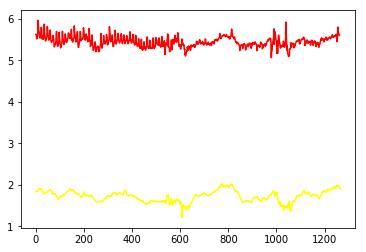

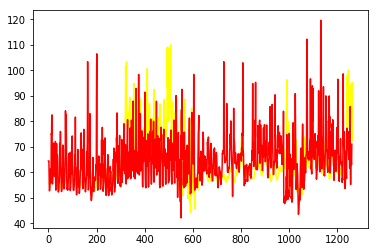

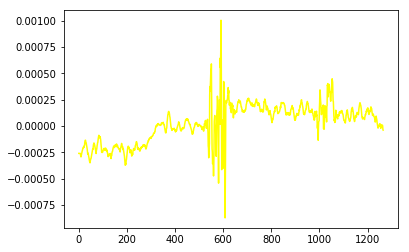

In [51]:
plt.figure()
print(np.shape(left_lane.all_fit), np.shape(right_lane.all_fit))

plt.plot(left_lane.all_offset, color='yellow')
plt.plot(right_lane.all_offset, color='red')

plt.figure()

plt.plot(20*np.log10(left_lane.all_curverad), color='yellow')
plt.plot(20*np.log10(right_lane.all_curverad), color='red')

plt.figure()

coeff2 = []
coeff1 = []
coeff0 = []
for item in left_lane.all_fit:
    coeff2.append(item[0])
    coeff1.append(item[1])
    coeff0.append(item[2])

plt.figure()

plt.plot(coeff2, color='yellow')

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Max: 255 Min: 0
14901.346669 m 2223.71529135 m
offset to center =  -0.0165571758294 m


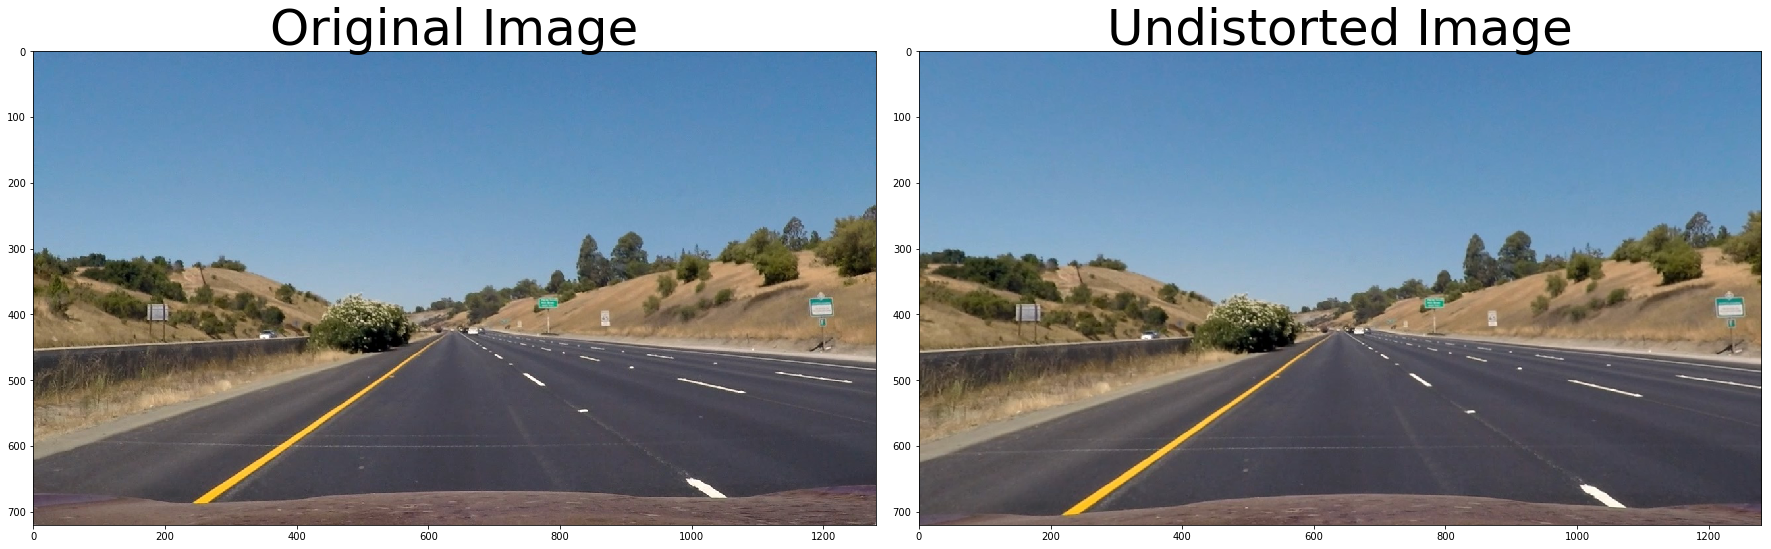

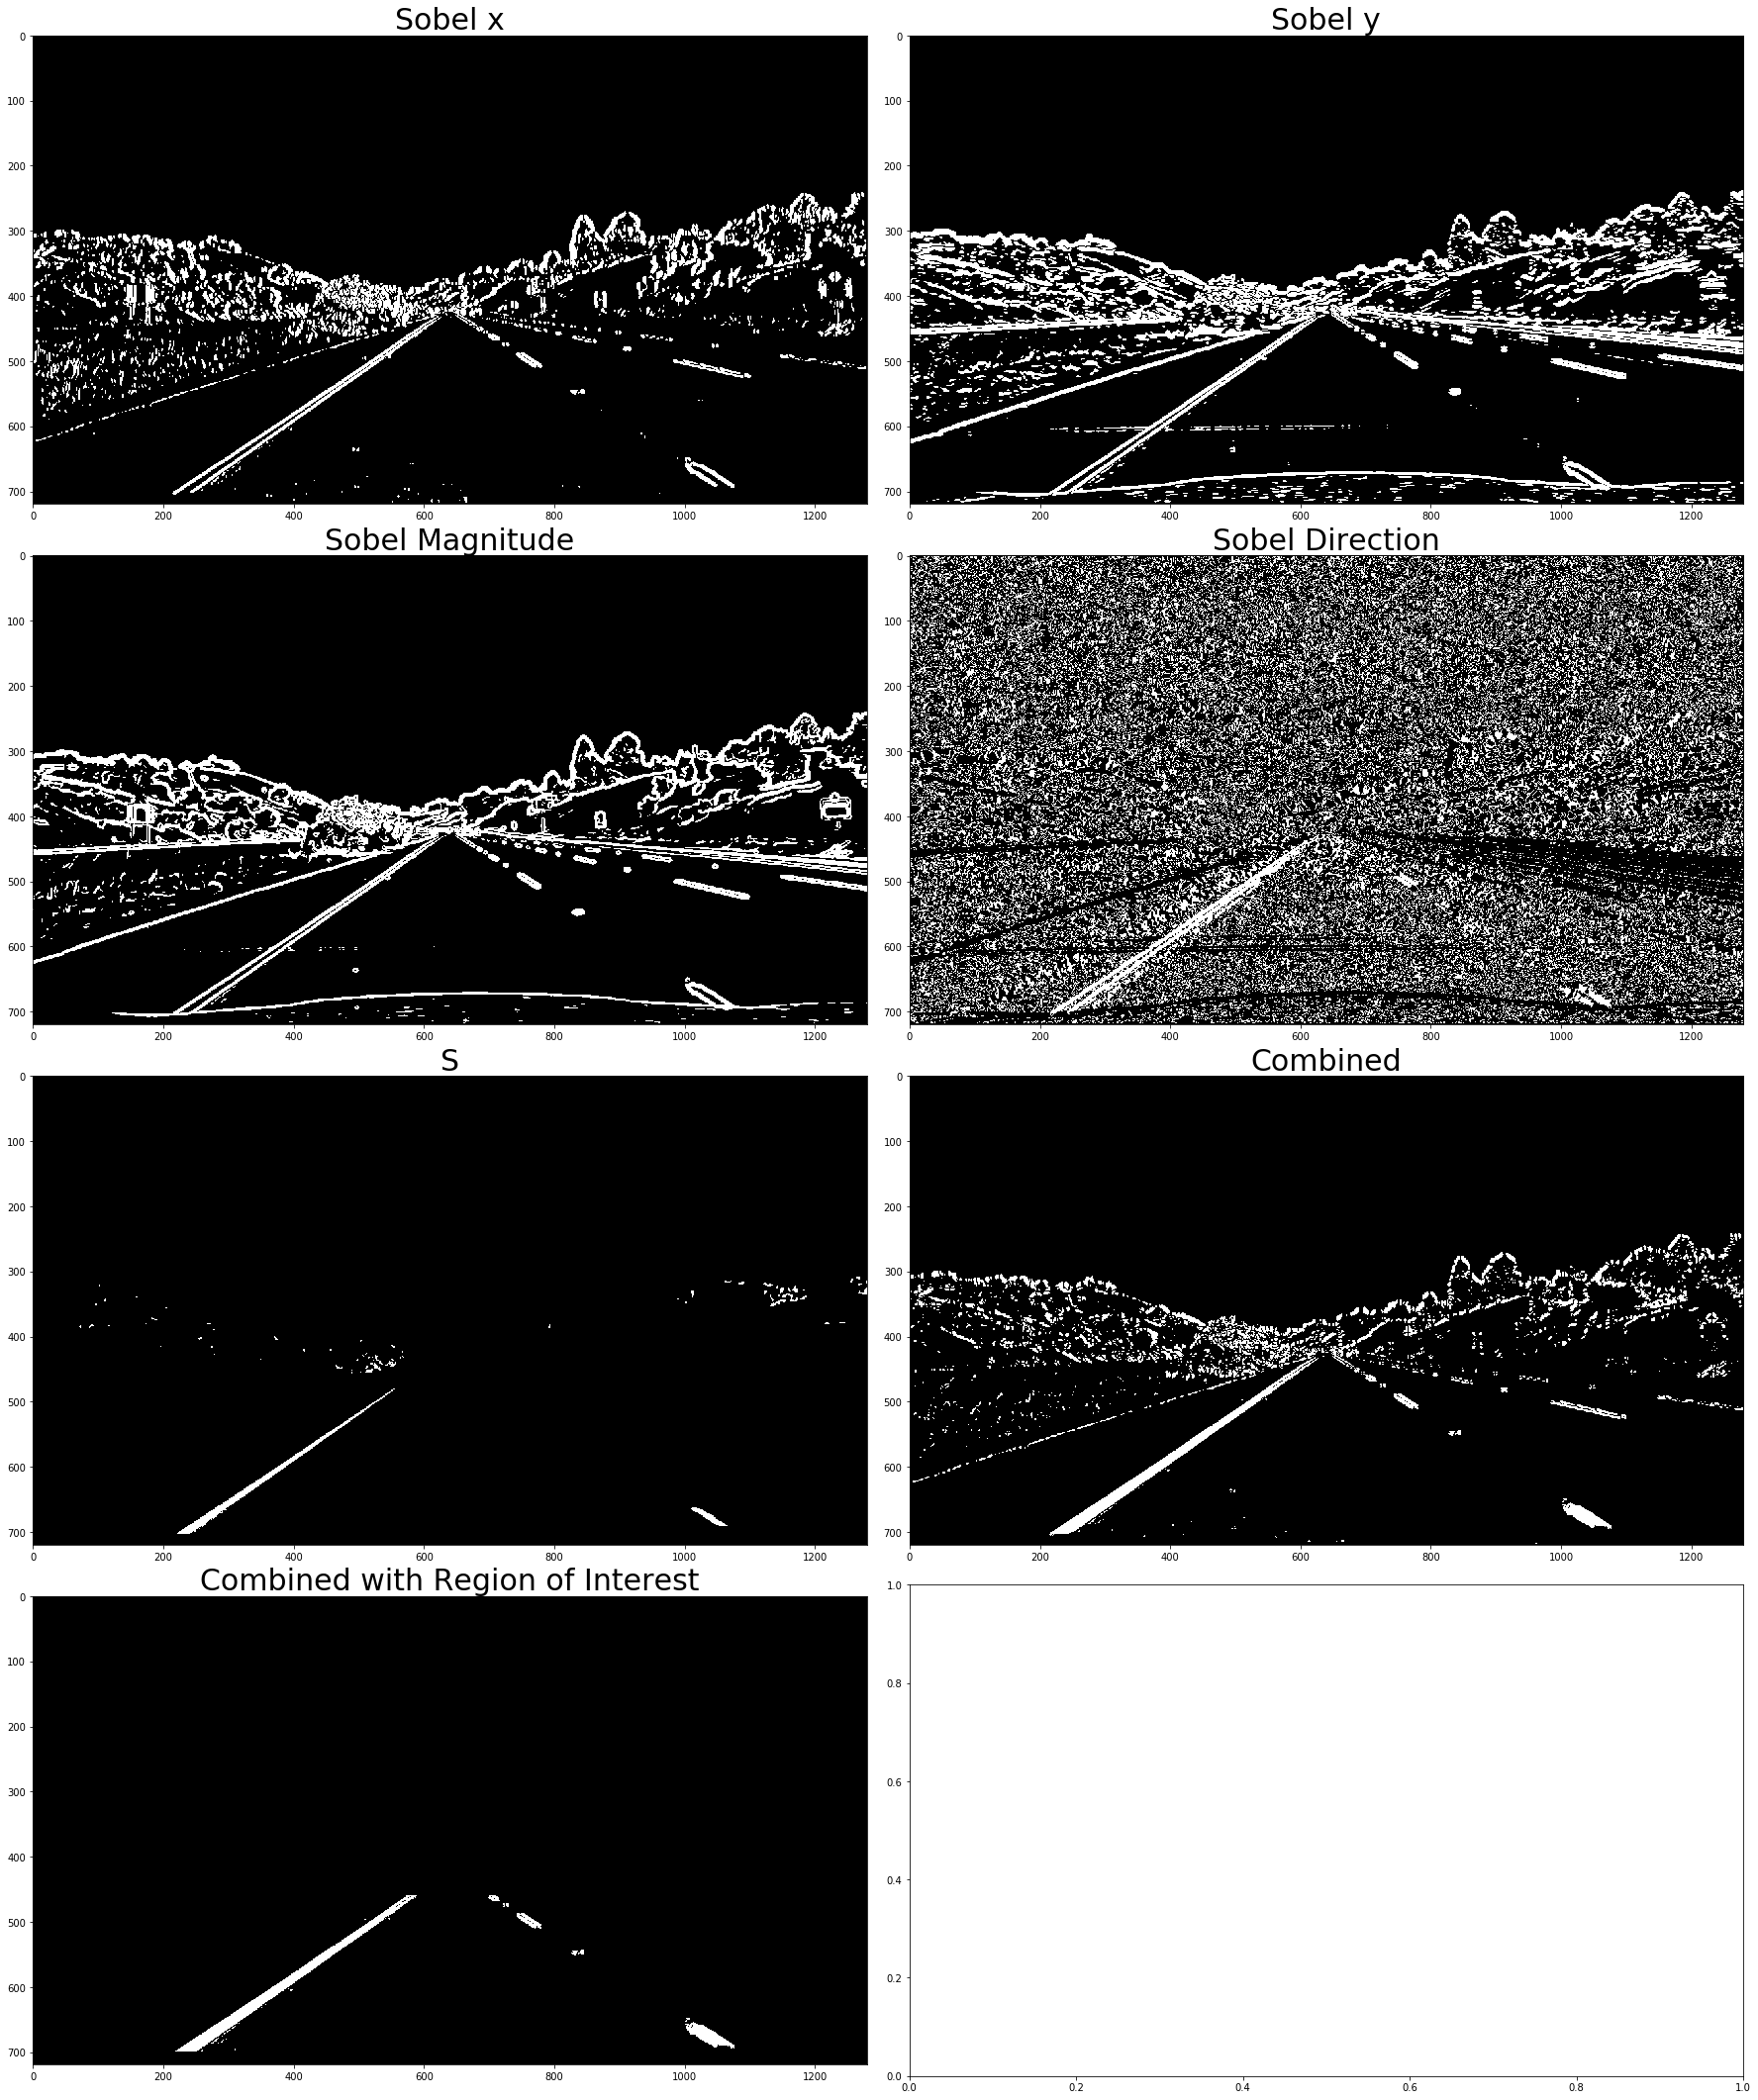

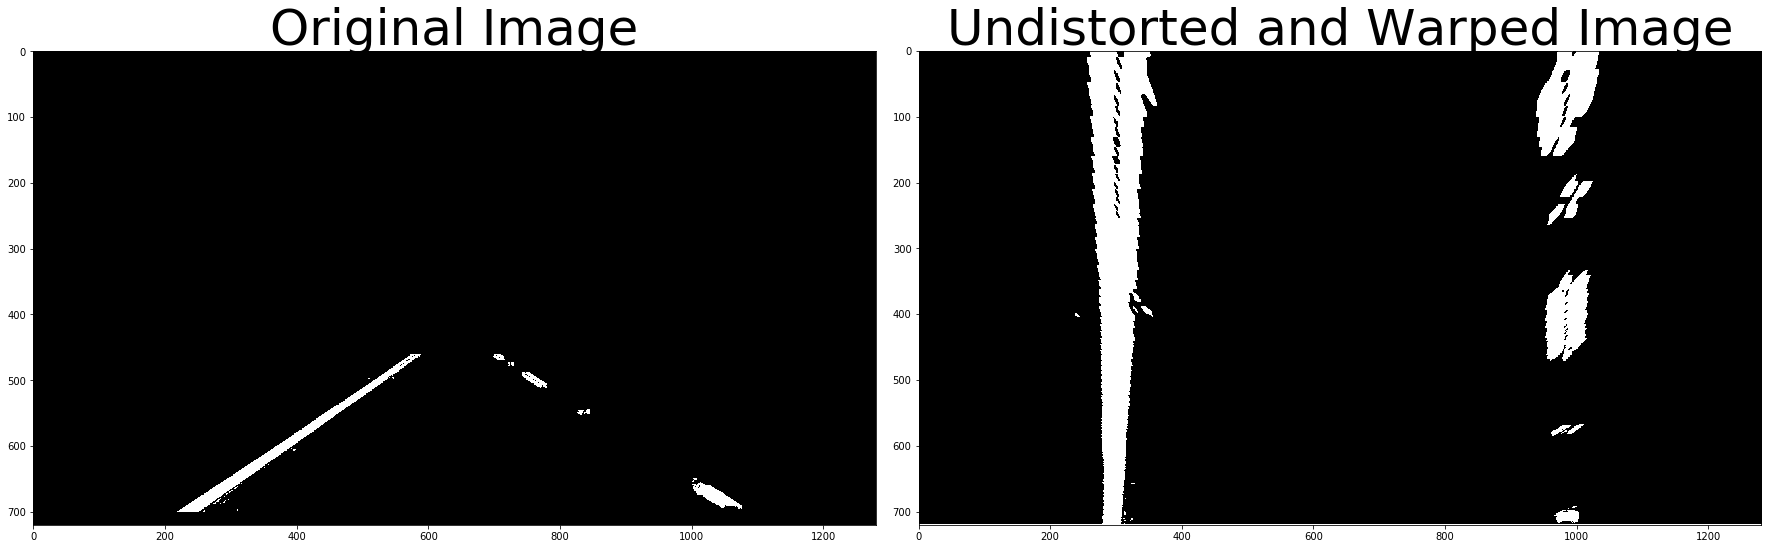

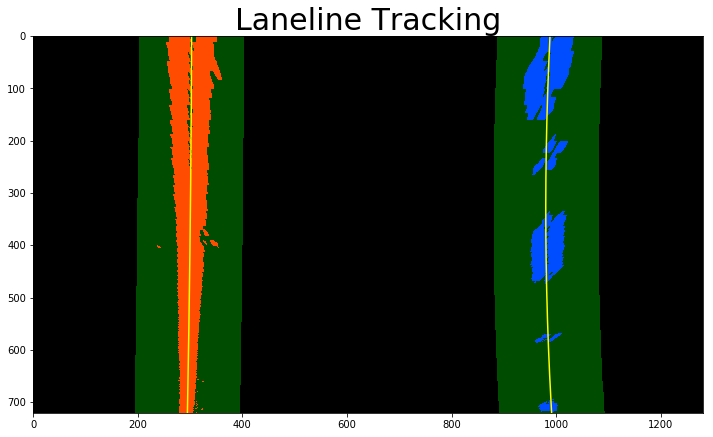

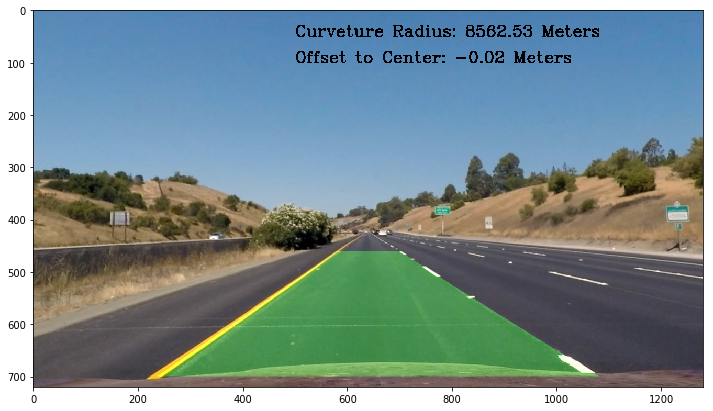

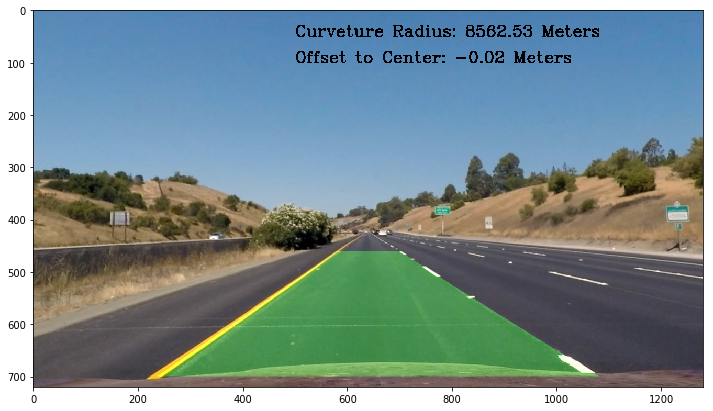

In [103]:
# left_lane = Line()
# right_lane = Line()
# single image test bench
image_list = os.listdir(test_images)
# print(image_list)
# image_file = image_list[4]
image_file = 'straight_lines1.jpg'
image = mpimg.imread(test_images + image_file)
print('This image is:', type(image), 'with dimesions:', image.shape)
print('Max:', image.max(), 'Min:', image.min())
lanemark_image = process_image(image, dbg = 1)
# plt.figure()
plt.figure(figsize = (12, 8))
plt.imshow(lanemark_image)

In [101]:
# x or y threshold
def abs_sobel_thresh(img, orient='x', sobel_kernel = 3, thresh = (0, 255)):
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary
    return binary_output
# magnitude threshold
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output
# direction threshold
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    angle_sobel = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(angle_sobel)
    binary_output[(angle_sobel >= thresh[0]) & (angle_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # 2) Apply a threshold to the S channel
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
def thresh_pipeline(img, sobel_kernel=3, abs_th=(20, 100), mag_th=(30, 100), dir_th=(0.7, 1.3), s_th=(170, 255), debug = 0):
    
    # Gaussian Blur, to reduce noise
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    # convert to GRAY image
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    sobelx_binary = abs_sobel_thresh(gray, orient='x', sobel_kernel=sobel_kernel, thresh = abs_th)
    sobely_binary = abs_sobel_thresh(gray, orient='y', sobel_kernel=sobel_kernel, thresh = abs_th)
    sobel_mag_binary = mag_thresh(gray, sobel_kernel=sobel_kernel, thresh = mag_th)
    sobel_dir_binary = dir_thresh(gray, sobel_kernel=sobel_kernel, thresh = dir_th)
    hls_binary = hls_select(img, thresh = s_th)
    combined_binary = np.zeros_like(sobelx_binary)
    combined_binary[(hls_binary == 1) | (((sobelx_binary == 1) & (sobely_binary == 1)) | ((sobel_mag_binary == 1) & (sobel_dir_binary == 1)))] = 1
    # further mask the image with region of interest
    # define region of interest for edge detection
    # Defining vertices for marked area
    im_xsize = combined_binary.shape[1]
    im_ysize = combined_binary.shape[0]
    x_ratio = im_xsize/1280
    y_ratio = im_ysize/720
    vertices = np.array([(np.round(230*x_ratio), np.round(700*x_ratio)), (np.round(580/x_ratio), np.round(460*y_ratio)), \
                          (np.round(702*x_ratio), np.round(460*y_ratio)), (np.round(1080*x_ratio), np.round(700*y_ratio))], dtype=np.int32)
    region_margin = 80
    p0 = (vertices[0][0]-region_margin, vertices[0][1])
    p1 = (vertices[1][0]-np.int(region_margin/3), vertices[1][1])
    p2 = (vertices[2][0]+np.int(region_margin/3), vertices[2][1])
    p3 = (vertices[3][0]+region_margin, vertices[3][1])
    p4 = (vertices[3][0]-region_margin, vertices[3][1])
    p6 = ((vertices[2][0] + vertices[1][0])/2, vertices[2][1] + 0)
    p5 = ((vertices[2][0] + vertices[1][0])/2, vertices[1][1] + 0)
    p7 = (vertices[0][0]+region_margin, vertices[0][1])
    mask_vertices = np.array([(p0, p1, p2, p3, p4, p5, p6, p7)], dtype=np.int32)
    # Masked area
    region_interest_binary = region_of_interest(combined_binary, mask_vertices)
    if debug:
        f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(24, 32))
        f.tight_layout()
        ax1.imshow(sobelx_binary, cmap='gray')
        ax1.set_title('Sobel x', fontsize=30)
        ax2.imshow(sobely_binary, cmap='gray')
        ax2.set_title('Sobel y', fontsize=30)
        ax3.imshow(sobel_mag_binary, cmap='gray')
        ax3.set_title('Sobel Magnitude', fontsize=30)
        ax4.imshow(sobel_dir_binary, cmap='gray')
        ax4.set_title('Sobel Direction', fontsize=30)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        ax5.imshow(hls_binary, cmap='gray')
        ax5.set_title('S', fontsize=30)
        ax6.imshow(combined_binary, cmap='gray')
        ax6.set_title('Combined', fontsize=30)
        ax7.imshow(region_interest_binary, cmap='gray')
        ax7.set_title('Combined with Region of Interest', fontsize=30)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.savefig('various_sobel_binary.png')
    return region_interest_binary

def find_window_centroids(warped, window_width, window_height, margin):
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        if 1:
            l_val_max = np.max(conv_signal[l_min_index:l_max_index])
            l_center = np.median(np.argwhere(conv_signal[l_min_index:l_max_index] == l_val_max))+l_min_index-offset
            r_val_max = np.max(conv_signal[r_min_index:r_max_index])
            r_center = np.median(np.argwhere(conv_signal[r_min_index:r_max_index] == r_val_max))+r_min_index-offset
        else:
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
    return window_centroids
 
# find the lanelines
def find_lanelines(binary_warped, mode = 0, left_fit_curr = [], right_fit_curr = [], detector = 'sliding_window', debug = 0):
    # Set the width of the windows +/- margin
    margin = 100
    if mode == 0: # laneline detect mode
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        if detector == 'histogram':
            # Assuming you have created a warped binary image called "binary_warped"
            # Take a histogram of the bottom half of the image
            histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]/2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint
            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base
            # Set minimum number of pixels found to recenter window
            minpix = 50
        if detector == 'sliding_window':
            window_width = 100 
            window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin)
            # print(window_centroids)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            if detector == 'histogram':
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
            if detector == 'sliding_window':
                win_xleft_low = np.int(window_centroids[window][0] - margin)
                win_xleft_high = np.int(window_centroids[window][0] + margin)
                win_xright_low = np.int(window_centroids[window][1] - margin)
                win_xright_high = np.int(window_centroids[window][1] + margin)
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            if detector == 'histogram':
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
            
    else: # laneline track mode
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        left_lane_inds = ((nonzerox > (left_fit_curr[0]*(nonzeroy**2) + left_fit_curr[1]*nonzeroy + left_fit_curr[2] - margin)) & (nonzerox < (left_fit_curr[0]*(nonzeroy**2) + left_fit_curr[1]*nonzeroy + left_fit_curr[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit_curr[0]*(nonzeroy**2) + right_fit_curr[1]*nonzeroy + right_fit_curr[2] - margin)) & (nonzerox < (right_fit_curr[0]*(nonzeroy**2) + right_fit_curr[1]*nonzeroy + right_fit_curr[2] + margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    if 0: # combine left and right lane
        lane_width = 700 # in pixel
        leftx = np.append(leftx, rightx - lane_width)
        lefty = np.append(lefty, righty)
        rightx = np.append(rightx, leftx + lane_width)
        righty = np.append(righty, lefty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit a second order polynomial to each
    lane_fit_update(left_lane, leftx, lefty, y_eval = binary_warped.shape[0])
    lane_fit_update(right_lane, rightx, righty, y_eval = binary_warped.shape[0])
    
    left_fit = left_lane.current_fit
    right_fit = right_lane.current_fit
    
    left_fit_cr = left_lane.current_fit_cir
    right_fit_cr = right_lane.current_fit_cir
    
    left_curverad = left_lane.current_curverad
    right_curverad = right_lane.current_curverad
    
    left_edge = left_lane.current_offset
    right_edge = right_lane.current_offset
    # curvature calculation
    # Fit new polynomials to x,y in world space
    # left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    # right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    # print(left_fit_cr, right_fit_cr)
    # y_eval = np.int(binary_warped.shape[0]/2)
    # y_eval = binary_warped.shape[0]
    #  left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    # right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # offset to center
    # left_edge = left_fit_cr[0]*(y_eval*ym_per_pix)**2 + left_fit_cr[1]*(y_eval*ym_per_pix) + left_fit_cr[2]
    # right_edge = right_fit_cr[0]*(y_eval*ym_per_pix)**2 + right_fit_cr[1]*(y_eval*ym_per_pix) + right_fit_cr[2]
    
    offset_to_center = binary_warped.shape[1]/2 * xm_per_pix - (left_edge + right_edge)/2
    
    if debug:# virtualization
        print(left_curverad, 'm', right_curverad, 'm')
        print('offset to center = ', offset_to_center, 'm')
        if mode == 0:
            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            plt.figure(figsize = (12, 8))
            plt.imshow(out_img)
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)
            plt.title('Laneline Detecting', fontsize=30)
            plt.savefig('lane_find_1.png')
        else:
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            # Create an image to draw on and an image to show the selection window
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
            window_img = np.zeros_like(out_img)
            # Color in left and right line pixels
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))
            plt.figure(figsize = (12, 8))
            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
            plt.imshow(result)
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)
            plt.title('Laneline Tracking', fontsize=30)
            plt.savefig('lane_find_2.png')
    return left_fit, right_fit, (left_curverad, right_curverad), offset_to_center

def lane_fit_update(lane_line, lane_x, lane_y, ym_per_pix = 30/720, xm_per_pix = 3.7/700, y_eval = 720):

    min_pixels = 10
    
    lane_line.frame_cnt += 1
    if len(lane_x) > min_pixels: # must has enough pixles
        lane_fit = np.polyfit(lane_y, lane_x, 2)
        lane_fit_cir = np.polyfit(lane_y*ym_per_pix, lane_x*xm_per_pix, 2)
        # Now our radius of curvature is in meters
        lane_curverad = ((1 + (2*lane_fit_cir[0]*y_eval*ym_per_pix + lane_fit_cir[1])**2)**1.5) / np.absolute(2*lane_fit_cir[0])
        # offset at bottom
        lane_offset = lane_fit_cir[0]*(y_eval*ym_per_pix)**2 + lane_fit_cir[1]*(y_eval*ym_per_pix) + lane_fit_cir[2]
        # for debug
        lane_line.all_fit.append(lane_fit)
        lane_line.all_fit_cir.append(lane_fit_cir)
        lane_line.all_curverad.append(lane_curverad)
        lane_line.all_offset.append(lane_offset)
        if lane_line.detected == 0:
            lane_line.current_fit = lane_fit
            lane_line.current_fit_cir = lane_fit_cir
            lane_line.current_curverad = lane_curverad
            lane_line.current_offset = lane_offset
            
            lane_line.detected = 1
            lane_line.mis_frame = 0
        else:
            # 1. fitting coefficients change
            # 2. radius is too small
            # 3. left_x or right_x change too much
            if (np.abs(lane_fit[0] - lane_line.current_fit[0]) <= 0.005) & (np.abs(lane_curverad) > 300) & (np.abs(lane_offset - lane_line.current_offset) < 50*xm_per_pix): # difference from current_fit must be small
            # update fitting information
                alpha = 0.9 #  alpha filtering
                lane_line.current_fit = lane_line.current_fit * alpha + (1-alpha) * lane_fit
                lane_line.current_fit_cir = lane_line.current_fit_cir * alpha + (1-alpha) * lane_fit_cir
                lane_line.current_curverad = lane_line.current_curverad * alpha + (1-alpha) * lane_curverad
                lane_line.current_offset = lane_line.current_offset * alpha + (1-alpha) * lane_offset
                
                lane_line.detected = 1
                lane_line.mis_frame = 0
            else: # no update, increase mis_frame by 1
                lane_line.mis_frame += 1
                print('Fitting failed @ Frame: ', lane_line.frame_cnt)
    else: # no update, increase mis_frame by 1
        lane_line.mis_frame += 1
        print('NOT enough pixels @ Frame: ', lane_line.frame_cnt)
    if lane_line.mis_frame >= 5: # detection failed
        lane_line.detected == 0
        print('Detection Failed @ Frame: ', lane_line.frame_cnt)
    
    # return new_lane = lane_line
    
# def process_image(image, dist_param, warp_param, dbg = 0):
def process_image(image, dbg = 0):
    # image_results = './' # image saving directory
    # step 1: undistort the image
    mtx = dist_param[0]
    dist = dist_param[1]
    image_undist = cv2.undistort(image, mtx, dist, None, mtx)
    if dbg == 1:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(image)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(image_undist)
        ax2.set_title('Undistorted Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.savefig('regular_image_cal.png')
    # step 2: detect edge with gradient and s-channel threshold
    sobel_kernel = 7
    abs_th = (20, 255)
    mag_th = (30, 255)
    dir_th = (0.6, 1.1)
    s_th = (160, 255)
    image_thresh = thresh_pipeline(image_undist, sobel_kernel=sobel_kernel, abs_th=abs_th, mag_th=mag_th, dir_th=dir_th, s_th=s_th, debug = dbg)
    # step 3: perspective transform
    M = warp_param[0]
    invM = warp_param[1]
    image_warped = cv2.warpPerspective(image_thresh, M, image_thresh.shape[1::-1], flags=cv2.INTER_LINEAR)
    if dbg == 1:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(image_thresh, cmap='gray')
        # ax1.plot(vertices[:, 0], vertices[:, 1], 'r--', lw=5)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(image_warped, cmap='gray')
        # ax2.plot(dst[:, 0], dst[:, 1], 'r--', lw=5)
        ax2.set_title('Undistorted and Warped Image', fontsize=50)
        ax2.set_xlim(0, 1280)
        ax2.set_ylim(720, 0)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.savefig('perspective.png')
    # step 4: find lanelines with sliding windows, and calculate curverature and offset from center
    if (left_lane.detected == 1) & (right_lane.detected == 1):
        [left_fit, right_fit, curverad, offset_to_center] = find_lanelines(image_warped, mode = 1, left_fit_curr = left_lane.current_fit, right_fit_curr = right_lane.current_fit, detector = 'histogram', debug = dbg)
    else: 
        [left_fit, right_fit, curverad, offset_to_center] = find_lanelines(image_warped, mode = 0, detector = 'histogram', debug = dbg)
    
    # step 5: revert the lanelines back to original image (undistorted)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, image_warped.shape[0]-1, image_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, invM, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    image_undist_lanemark= cv2.addWeighted(image_undist, 1, newwarp, 0.3, 0)
    # put text on image
    cv2.putText(image_undist_lanemark, text='Curveture Radius: '+str(round(np.mean(curverad), 2))+' Meters', org=(500,50),fontFace=3, fontScale=1, color=(0,0,0), thickness=2)
    cv2.putText(image_undist_lanemark, text='Offset to Center: '+str(round(offset_to_center, 2))+' Meters', org=(500,100),fontFace=3, fontScale=1, color=(0,0,0), thickness=2)

    if dbg == 1:
        plt.figure(figsize = (12, 8))
        plt.imshow(image_undist_lanemark)
        plt.savefig('lane_line_add.png')
        # plt.text(800, 50, 'Curveture Radius: '+str(round(np.mean(curverad), 2))+' Meters', fontsize = 12)
        # plt.text(800, 100, 'Offset to Center: '+str(round(offset_to_center, 2))+' Meters', fontsize = 12)

    
    return image_undist_lanemark